In [1]:
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import tensorflow as tf
path = '/data/counting_cell_dataset'

In [2]:
def get_batch_test(batch, path):
    """create 2 lists of images, one for the input and one for output
    We have 200 images, the input is cell and the output is the number of dot"""
    cells = []
    dots = []
    images_index = np.random.randint(150, 201, size=batch)
    for index in images_index:
        if index < 10:
            full_path_cells = str(path + "/00%s"%index + "cell.png")
            full_path_dots = str(path + "/00%s"%index + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
        elif index < 100:
            full_path_cells = str(path + "/0%s"%index + "cell.png")
            full_path_dots = str(path + "/0%s"%index + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
        elif index >= 100:
            full_path_cells = str(path + "/" + str(index) + "cell.png")
            full_path_dots = str(path + "/" + str(index) + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
    return cells, dots

In [3]:
def get_batch(batch, path):
    """create 2 lists of images, one for the input and one for output
    We have 200 images, the input is cell and the output is the number of dot"""
    cells = []
    dots = []
    images_index = np.random.randint(1, 150, size=batch)
    for index in images_index:
        if index < 10:
            full_path_cells = str(path + "/00%s"%index + "cell.png")
            full_path_dots = str(path + "/00%s"%index + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
        elif index < 100:
            full_path_cells = str(path + "/0%s"%index + "cell.png")
            full_path_dots = str(path + "/0%s"%index + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
        elif index >= 100:
            full_path_cells = str(path + "/" + str(index) + "cell.png")
            full_path_dots = str(path + "/" + str(index) + "dots.png")
            cell = cv2.imread(full_path_cells)
            dot = cv2.imread(full_path_dots)
            cells.append(cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)/30.0)
            dots.append(cv2.countNonZero(cv2.imread(full_path_dots, 0)))
    return cells, dots

In [4]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pooling(x,k):
    return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')

def avg_pooling(x, k):
    return tf.nn.avg_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')


In [5]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None,256, 256, 1])
y_ = tf.placeholder(tf.float32, shape=[None, 1])


W1 = weight_variable([7, 7, 1, 5])
b1 = bias_variable([5])
x_conv1 = tf.nn.relu(tf.add(conv2d(x, W1), b1))
x_pool1 = avg_pooling(x_conv1,3)


W2 = weight_variable([3, 3, 5, 10])
b2 = bias_variable(([10]))
x_conv2 = tf.nn.relu(tf.add(conv2d(x_pool1, W2), b2))
x_pool2 = avg_pooling(x_conv2,4)


W3 = weight_variable([3, 3, 10, 5])
b3 = bias_variable([5])
x_conv3 = tf.nn.relu(tf.add(conv2d(x_pool2, W3), b3))
x_pool3 = max_pooling(x_conv3,3)


# Flatten
x_flat = tf.reshape(x_pool3, [-1, 8* 8 * 5])

W_fc1 = weight_variable([8 * 8 * 5, 320])
b_fc1 = bias_variable(([1, 320]))
x_fc1 = tf.nn.relu(tf.add(tf.matmul(x_flat, W_fc1), b_fc1))

# Regularization with dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# Classification layer   1024 --> 10
W_fc2 = weight_variable([320, 1])
b_fc2 = bias_variable(([1]))
y_est = tf.add(tf.matmul(x_fc1_drop, W_fc2), b_fc2)

mse = tf.losses.mean_squared_error(y_, y_est)
Optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mse)

In [13]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

In [14]:
# Train model
# Run once to get the model to a good confidence level
nb_batch = 20
nb_iter = 1500
loss = []
loss_test = []
image_test, labels_test = get_batch_test(nb_batch, path)
labels_test = np.expand_dims(np.stack(labels_test),1)
for i in range(nb_iter):
    images, labels = get_batch(nb_batch, path)
    labels = np.expand_dims(np.stack(labels),1) 

    Optimizer.run(feed_dict={x:np.array(images).reshape(nb_batch, 256, 256,1), y_: labels, keep_prob:0.5})
    loss.append(sess.run(mse ,feed_dict={x: np.array(images).reshape(nb_batch, 256, 256,1), y_: labels, keep_prob:1}))
    loss_test.append(sess.run(mse ,feed_dict={x: np.array(image_test).reshape(nb_batch, 256, 256,1), y_: labels_test, keep_prob:1}))
    if i % 5 == 0:
        print(i)
print("Done")

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995
1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
12

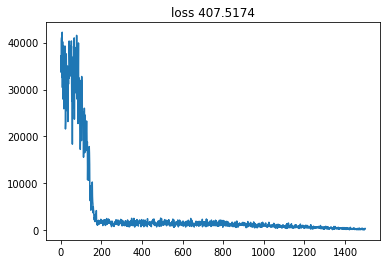

In [15]:
plt.plot(loss);
plt.title("loss %s"%loss[-1]);

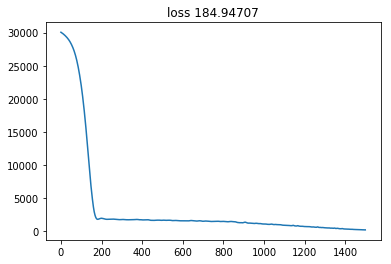

In [16]:
plt.plot(loss_test);
plt.title("loss %s"%loss_test[-1]);